In [1]:
!nvidia-smi

Mon Nov  6 18:48:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8              N/A / 115W |    571MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pathlib
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.experimental.set_virtual_device_configuration(
    physical_devices[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*15)])

In [5]:
IMG_SIZE=(720,480)
batch_size = 32
channels = 3
epochs = 10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data_temp/",
    shuffle=True,
    image_size = IMG_SIZE,
    batch_size = batch_size
    )

Found 3804 files belonging to 19 classes.


In [7]:
class_names = dataset.class_names
# class_names

In [8]:
# # Count the number of images in each class
# class_counts = []
# for class_name in class_names:
#     class_dir = pathlib.Path("data_temp/") / class_name
#     num_images = len(list(class_dir.glob('*')))
#     class_counts.append(num_images)
    
# class_weights = {}
# for class_idx in range(len(class_counts)):
#   if class_counts[class_idx] != 0:
#     class_weights[class_idx] = total_samples / (class_counts[class_idx] * len(class_counts))

# for class_idx in range(len(class_names)):
#   print(f"{class_names[class_idx]}: {class_counts[class_idx]}")

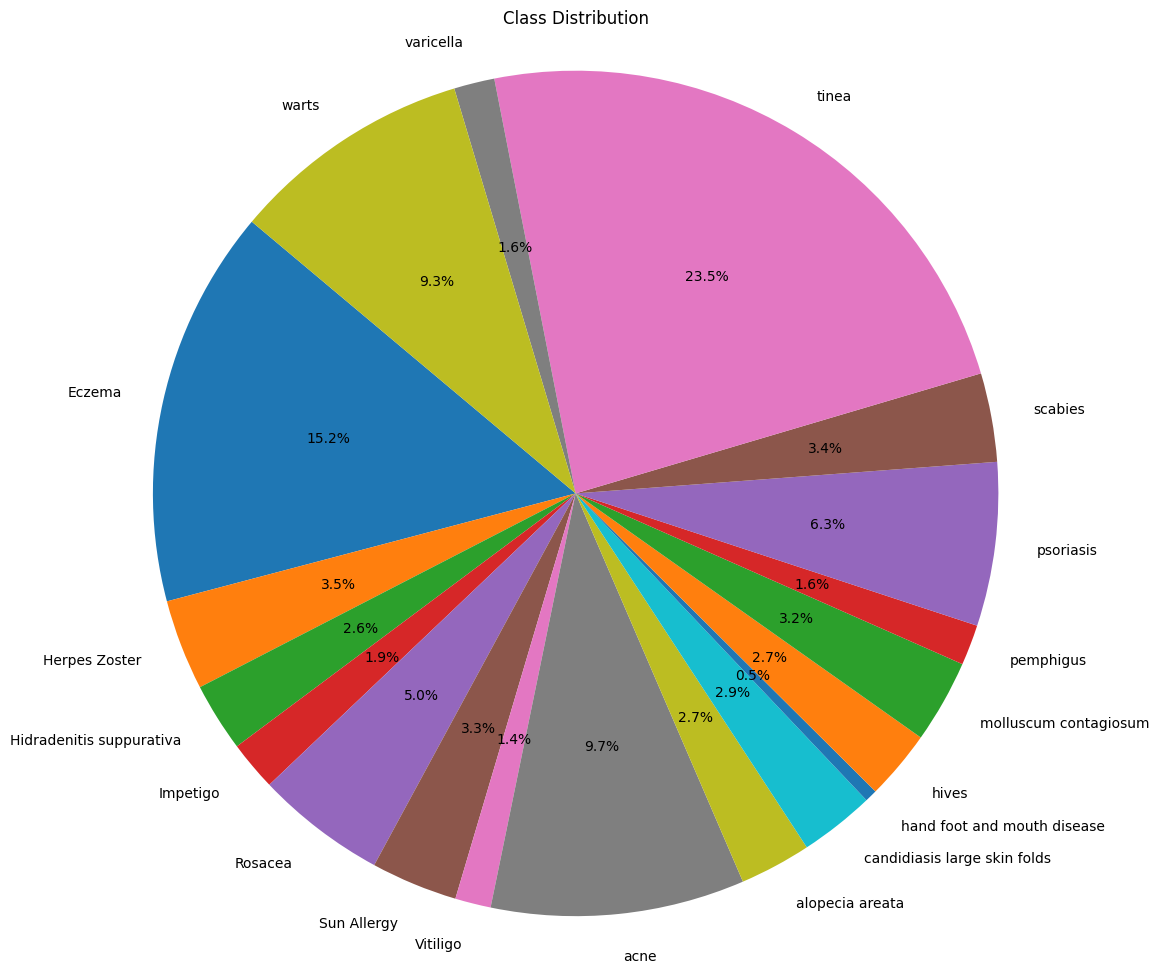

In [9]:
# Count the number of images in each class
class_counts = []
for class_name in class_names:
    class_dir = pathlib.Path("data_temp/") / class_name
    num_images = len(list(class_dir.glob('*')))
    class_counts.append(num_images)

# Plot a pie chart for class distribution
plt.figure(figsize=(12, 12))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2,shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)


    return train_ds, val_ds

In [11]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

95

In [13]:
len(val_ds)

23

In [14]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
base_model =tf.keras.applications.EfficientNetB5(include_top=False,
                                                    weights='imagenet'
                                                   )
    
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(720, 480, 3), name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(19, activation="softmax", name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [16]:
train_ds = train_ds.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))

In [17]:
# Calculate class weights based on class distribution
total_samples = sum(class_counts)
class_weights = {class_idx: total_samples / (class_counts[class_idx] * len(class_counts)) for class_idx in range(len(class_counts))}
# Define a custom callback to set class weights during training
class WeightedLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, class_weights):
        super(WeightedLossCallback, self).__init__()
        self.class_weights = class_weights

    def on_epoch_begin(self, epoch, logs=None):
        self.model.loss_weights = [self.class_weights]

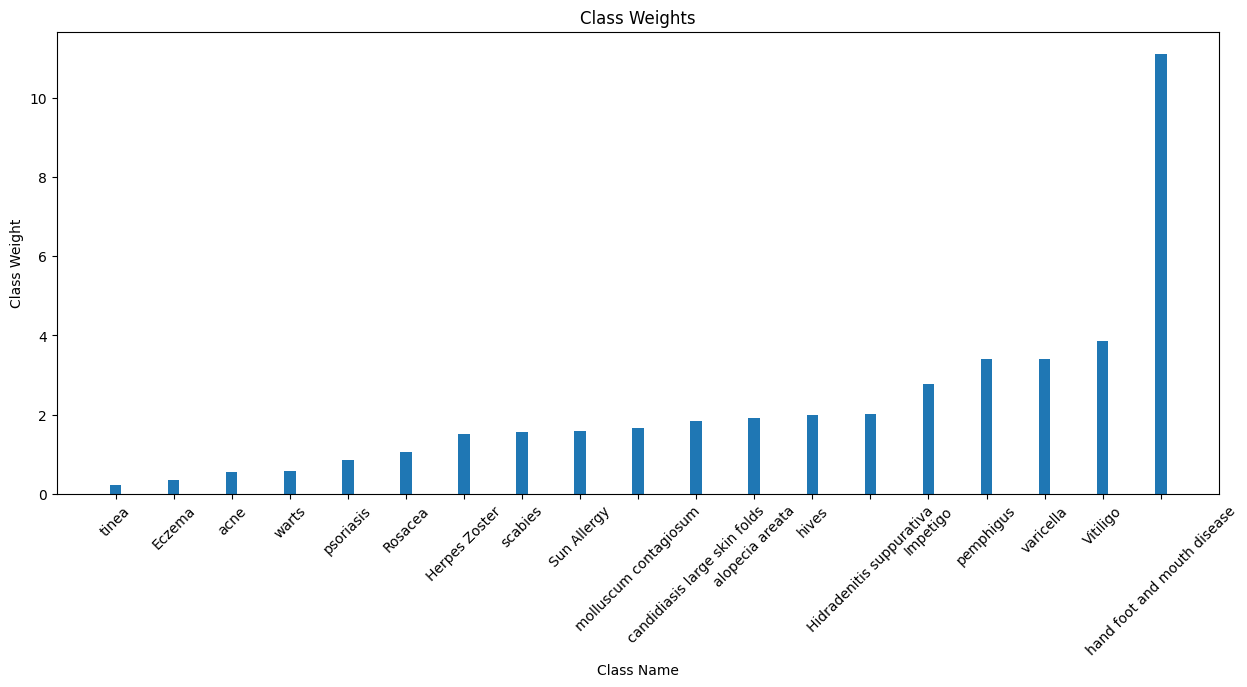

In [18]:
class_weights = {}
for class_idx in range(len(class_counts)):
    if class_counts[class_idx] != 0:
        class_weights[class_names[class_idx]] = total_samples / (class_counts[class_idx] * len(class_counts))

# for class_idx in range(len(class_names)):
#   print(f"{class_names[class_idx]}: {class_weights[class_idx]}")

# Convert the dictionary to a list of tuples for sorting and extracting class names and weights
# Sort the class names and weights based on class weights
sorted_class_names = sorted(class_weights, key=class_weights.get)
sorted_weights = [class_weights[class_name] for class_name in sorted_class_names]

plt.figure(figsize=(15, 6))
plt.bar(sorted_class_names, sorted_weights, width=0.2)
plt.xlabel("Class Name")
plt.ylabel("Class Weight")
plt.title("Class Weights")
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

In [19]:
history = model_0.fit(train_ds,
           epochs=100,
           steps_per_epoch=len(train_ds),
           validation_data=val_ds,
           validation_steps=int(0.25*len(val_ds))
            , callbacks=[WeightedLossCallback(class_weights)]
)
           # , callbacks=[WeightedLossCallback(class_weights)]

Epoch 1/100
95/95 [==============================] - 256s 2s/step - loss: 2.3771 - accuracy: 0.2806 - val_loss: 2.0076 - val_accuracy: 0.3750
Epoch 2/100
95/95 [==============================] - 133s 1s/step - loss: 1.9656 - accuracy: 0.3982 - val_loss: 1.6600 - val_accuracy: 0.4563
Epoch 3/100
95/95 [==============================] - 110s 1s/step - loss: 1.7505 - accuracy: 0.4493 - val_loss: 1.5715 - val_accuracy: 0.5312
Epoch 4/100
95/95 [==============================] - 110s 1s/step - loss: 1.5620 - accuracy: 0.5059 - val_loss: 1.1935 - val_accuracy: 0.6000
Epoch 5/100
95/95 [==============================] - 110s 1s/step - loss: 1.4531 - accuracy: 0.5343 - val_loss: 1.2506 - val_accuracy: 0.6000
Epoch 6/100
95/95 [==============================] - 110s 1s/step - loss: 1.3244 - accuracy: 0.5777 - val_loss: 1.0812 - val_accuracy: 0.6438
Epoch 7/100
95/95 [==============================] - 110s 1s/step - loss: 1.2390 - accuracy: 0.6094 - val_loss: 1.1473 - val_accuracy: 0.6562
Epoch 

In [20]:
scores = model_0.evaluate(val_ds)

23/23 [==============================] - 43s 2s/step - loss: 0.2091 - accuracy: 0.9511


In [21]:
scores

[0.20911496877670288, 0.9510869383811951]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 95}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['accuracy']

[0.2806324064731598,
 0.39822134375572205,
 0.4492753744125366,
 0.5059288740158081,
 0.5342556238174438,
 0.5777338743209839,
 0.6093544363975525,
 0.6231883764266968,
 0.6617259383201599,
 0.6732543110847473,
 0.6999341249465942,
 0.7229907512664795,
 0.7417654991149902,
 0.7628458738327026,
 0.7727272510528564,
 0.7928194999694824,
 0.8020421862602234,
 0.8132411241531372,
 0.8270751237869263,
 0.8428853750228882,
 0.8514492511749268,
 0.8689064383506775,
 0.8735178112983704,
 0.8787878751754761,
 0.8876811861991882,
 0.8985507488250732,
 0.9094203114509583,
 0.9110671877861023,
 0.9156785011291504,
 0.9212779998779297,
 0.9249011874198914,
 0.9374176263809204,
 0.9463109374046326,
 0.9440052509307861,
 0.9519104361534119,
 0.950263500213623,
 0.9571805000305176,
 0.9538866877555847,
 0.9617918133735657,
 0.9660738110542297,
 0.9683794379234314,
 0.9611330628395081,
 0.9634387493133545,
 0.9713438749313354,
 0.9664031863212585,
 0.9726613759994507,
 0.981225311756134,
 0.98287218809

In [26]:
len(history.history['accuracy'])

100

In [27]:
epochs = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

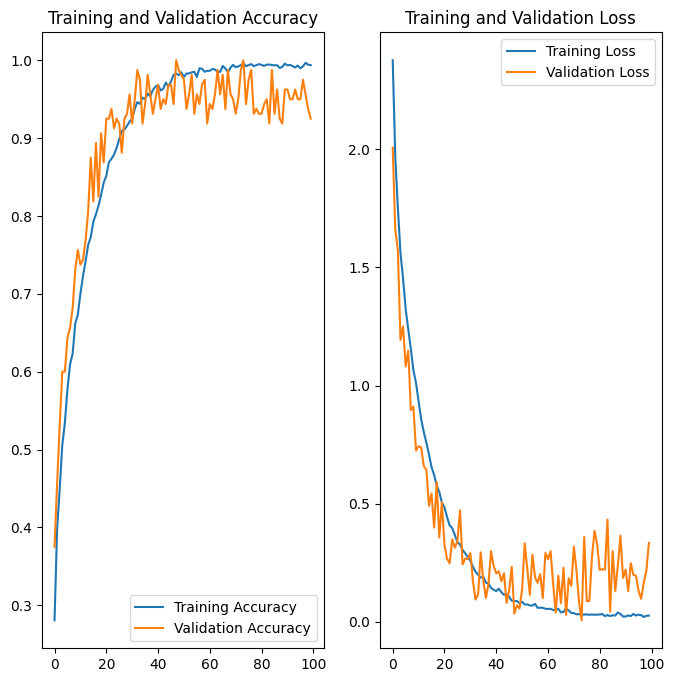

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: tinea
1/1 [==============================] - 3s 3s/step
Predicted Label tinea


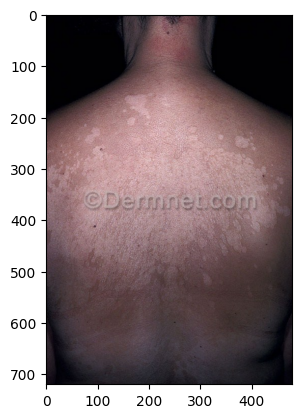

In [29]:
for images_batch, label_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model_0.predict(images_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


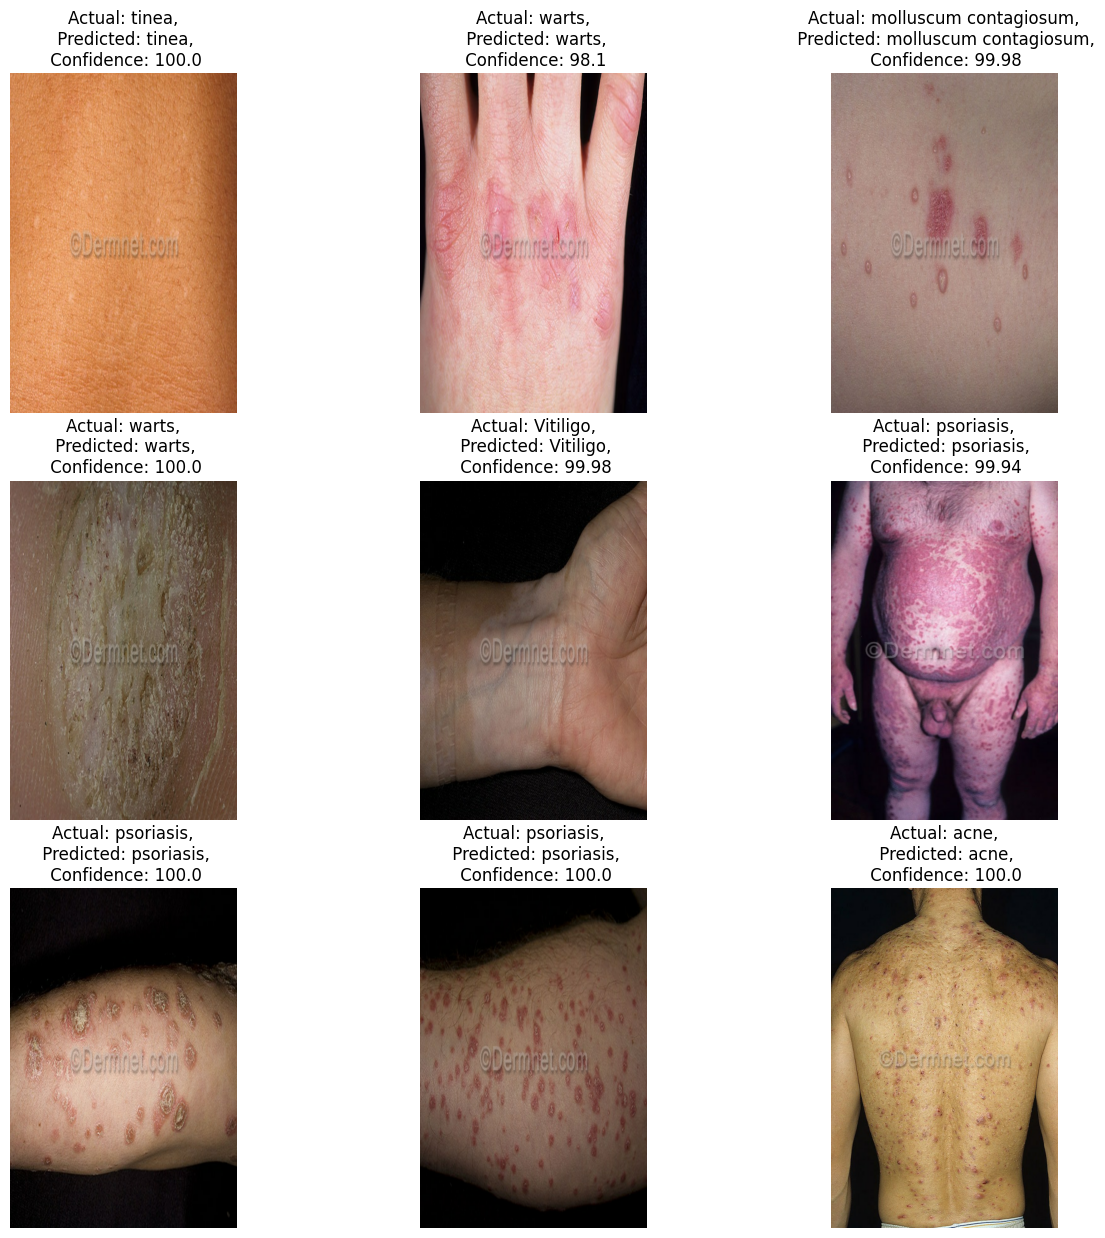

In [31]:
plt.figure(figsize=(15,15))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model_0, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}')

        plt.axis("off")

In [32]:
model_0.save("19 most common skin lesions classification Model.h5") 

In [33]:
# Make predictions with model
preds_probs = model_0.predict(val_ds, verbose=1) # set verbosity to see how long is left

23/23 [==============================] - 44s 2s/step


In [34]:
len(val_ds)

23

In [35]:
# How many predictions are there?
len(preds_probs)
     

736

In [36]:
# What's the shape of our predictions?
preds_probs.shape

(736, 19)

In [37]:
# Let's see what the first 10 predictions look like
preds_probs[:5]
     

array([[1.54949409e-09, 5.94986416e-09, 8.20001289e-11, 1.35177970e-06,
        4.21110412e-12, 2.86512654e-11, 6.64307220e-10, 1.03556603e-08,
        2.65777000e-08, 1.39176531e-10, 1.60967403e-07, 5.74760017e-09,
        3.84834120e-09, 8.36942293e-10, 2.37079023e-09, 6.67650868e-09,
        4.02111618e-06, 2.20406429e-10, 9.99994397e-01],
       [2.94796720e-09, 4.21496679e-07, 1.34079627e-07, 1.67413575e-07,
        3.06558201e-09, 1.69481351e-09, 1.74191577e-08, 2.32051661e-06,
        4.28200423e-07, 3.56489793e-09, 3.72016871e-08, 5.19582732e-09,
        1.36409180e-05, 2.41354343e-07, 4.73028166e-07, 6.40864215e-08,
        2.04410355e-07, 9.99981761e-01, 4.08285317e-08],
       [1.53998014e-09, 1.89538912e-06, 9.10419917e-09, 2.51166483e-08,
        1.31835598e-09, 2.99469249e-08, 4.45970363e-05, 6.37065192e-11,
        9.99908447e-01, 5.22813903e-10, 1.42946746e-07, 1.30563942e-08,
        1.83740863e-08, 3.27558336e-09, 1.38833223e-09, 4.40343451e-09,
        4.48256687e-05

In [38]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.5494941e-09, 5.9498642e-09, 8.2000129e-11, 1.3517797e-06,
        4.2111041e-12, 2.8651265e-11, 6.6430722e-10, 1.0355660e-08,
        2.6577700e-08, 1.3917653e-10, 1.6096740e-07, 5.7476002e-09,
        3.8483412e-09, 8.3694229e-10, 2.3707902e-09, 6.6765087e-09,
        4.0211162e-06, 2.2040643e-10, 9.9999440e-01], dtype=float32),
 19,
 0.9999999960783326)

In [39]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 19
What prediction probability sample 0 looks like:
 [1.5494941e-09 5.9498642e-09 8.2000129e-11 1.3517797e-06 4.2111041e-12
 2.8651265e-11 6.6430722e-10 1.0355660e-08 2.6577700e-08 1.3917653e-10
 1.6096740e-07 5.7476002e-09 3.8483412e-09 8.3694229e-10 2.3707902e-09
 6.6765087e-09 4.0211162e-06 2.2040643e-10 9.9999440e-01]
The class with the highest predicted probability by the model for sample 0: 18


In [40]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([18, 17,  8, 18,  0,  8, 16,  4, 16, 16], dtype=int64)

In [23]:
# Create a list to store class labels for each image
class_labels = []

# Iterate through the dataset to assign class names to images
for images, labels in dataset.unbatch():
    # Find the class index using argmax if it's in one-hot format
    class_index = labels.numpy().argmax() if len(labels.numpy().shape) > 1 else int(labels.numpy())

    # Get the class name using the class index
    class_label = class_names[class_index]

    # Append the class label to the list
    class_labels.append(class_label)

In [28]:
class_labels[20]

'warts'

In [22]:
# To get our test labels we need to unravel our val_data BatchDataset (Unbatch dataset)
y_labels = []
for images, labels in val_ds.unbatch():
    # Get the index of the maximum value in the label tensor
    non_zero_indices = np.where(labels)[0]
    if non_zero_indices:
        label_value = non_zero_indices[0]
        y_labels.append(label_value)
    # print(f"Label: {label_value}")

y_labels[:10]# currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index va

[]

In [42]:
# Look at the first 10
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
# How many y_labels are there?
len(y_labels)

736

In [44]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")